#**LSTM Deep Learning Model**

- LSTM cells are designed to capture long-term dependencies in sequential data by selectively remembering and forgetting information over time.
- They use gates to control the flow of information into and out of the cell state, making them effective for tasks requiring modeling of context and sequential patterns.

### LSTM Cell Working

**Input Reception:**
At each time step, the LSTM cell receives input data and the previous hidden state from the preceding cell in the sequence.

**Forget Gate:**
This gate decides which information from the previous cell state to forget based on the current input and previous hidden state. It selectively removes information that is deemed irrelevant for the current prediction.

**Input Gate:**
The input gate determines which new information to store in the cell state. It uses the current input and previous hidden state to update the cell state with new information that is relevant for the current time step.

**Cell State Update:**
The cell state is updated by combining the information retained from the forget gate and the new information selected by the input gate. This step ensures that the LSTM cell can maintain long-term dependencies by selectively updating its internal memory.

**Output Gate:**
Finally, the output gate decides which part of the cell state should be output as the hidden state to the next LSTM cell or as the final prediction of the network. It controls the flow of information from the LSTM cell to the next step in the sequence or to the output layer of the network.


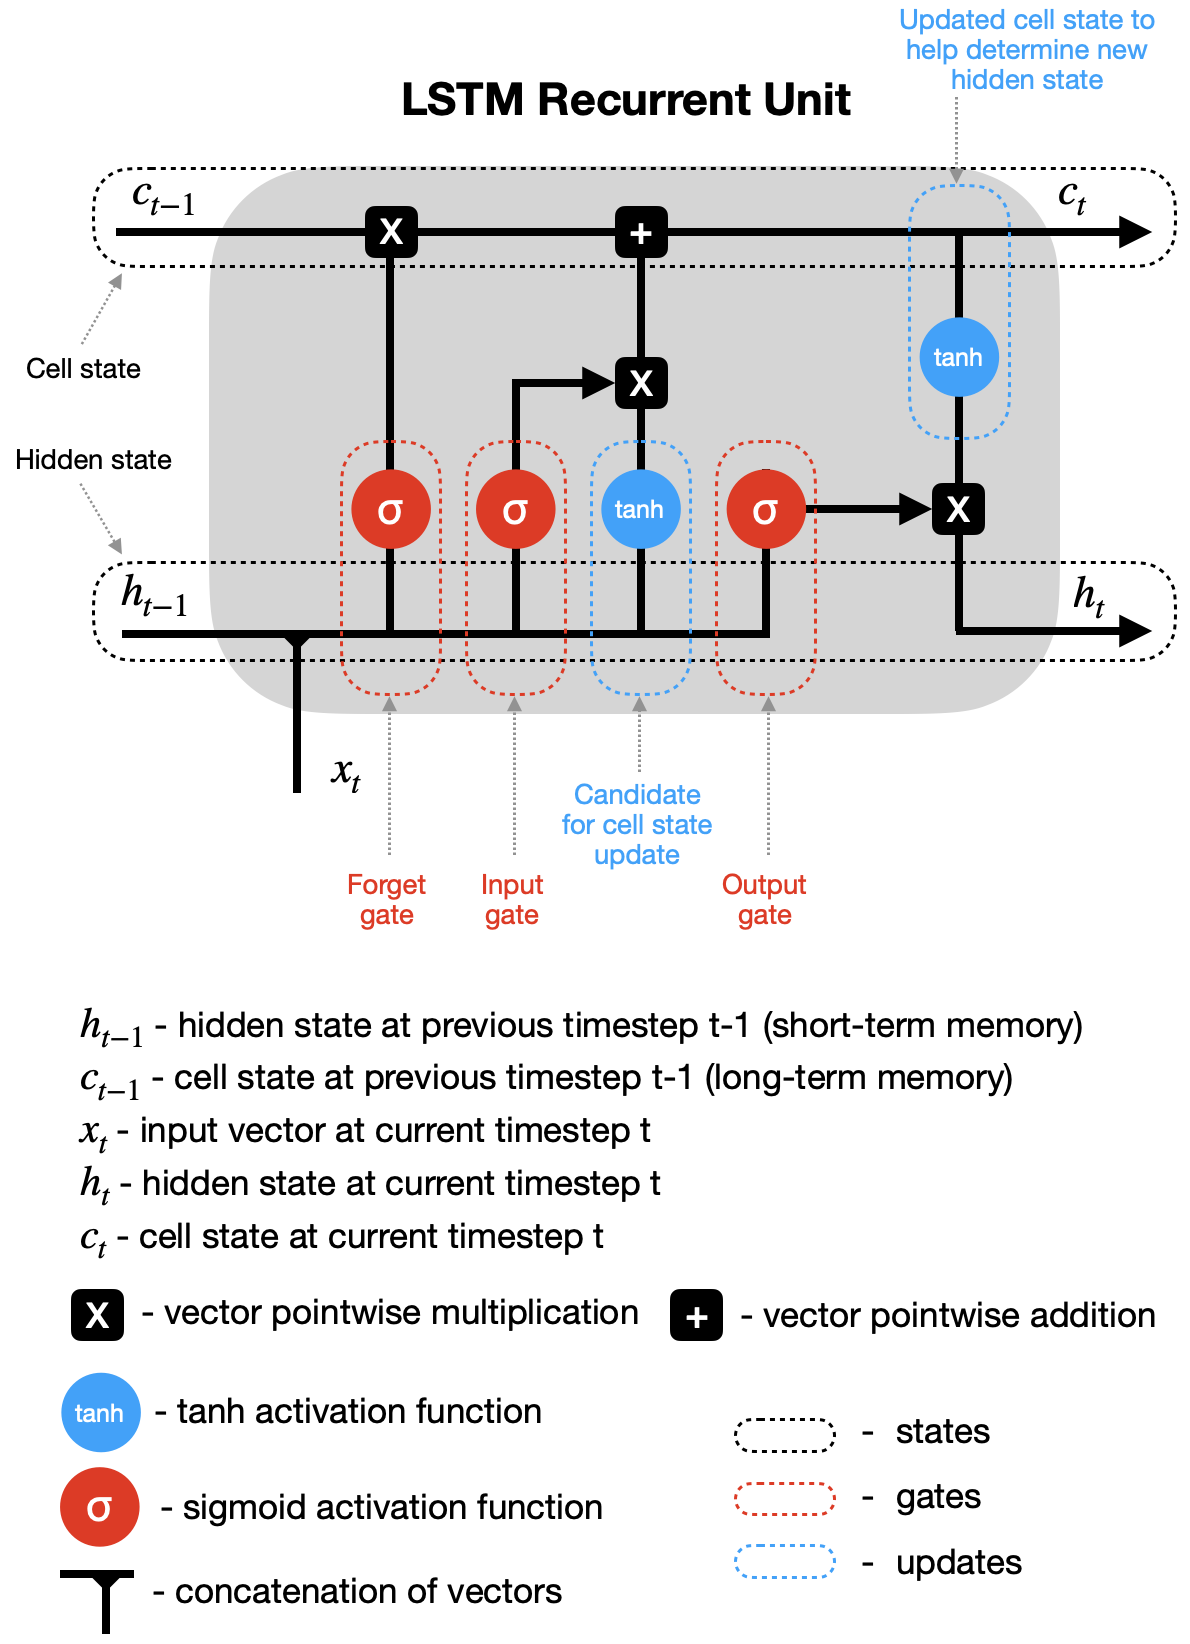

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing the necessary packages and dataset**

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional, Conv1D, MaxPooling1D, InputLayer,Embedding
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer


In [3]:
file_path1 = '/content/drive/MyDrive/Colab Notebooks/reviews_dataset.xlsx'
df = pd.read_excel(file_path1)

In [4]:
df

,reviews,Sarcasm
0,One reviewer mention watch 1 Oz episode youll ...,0
1,wonderful little production. filming technique...,0
2,movie groundbreaking experience! Ive never see...,1
3,think wonderful way spend time hot summer week...,0
4,Basically family little boy Jake think zombie ...,1
...,...,...
6492,movie idea character development muscle less b...,1
6493,guess run budget decent script.,1
6494,need plot explosion every five minutes?,1
6495,award generic action movie ever made?,1


**Spliting the dataset into train and test data**

In [9]:
X=df['reviews']
Y=df['Sarcasm']
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [10]:
X_train

1916    Ive already see spinoffs cartoon Flintstones S...
947     probably one bad movie ever made. Bad act bad ...
877     Paint number story mediocre act save authentic...
2927    first murder scene one best murder film histor...
6063    Bravo another movie hero deep puddle rain shower.
                              ...                        
3772    love movie manage suck joy life. like black ho...
5191    Yet another adventure movie protagonist intere...
5226       Yet another forgettable action flick surprise.
5390                       Id rather stick elevator mime.
860     Boris Karloff Bela Lugosi make many film toget...
Name: reviews, Length: 5197, dtype: object

**Tokenization and Embeddings**

In [23]:
# Tokenizer and padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_ = pad_sequences(X_train_seq, padding='post')

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_ = pad_sequences(X_test_seq, padding='post', maxlen=X_train_.shape[1])

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1
max_length = X_train_.shape[1]


In [24]:
X_train_

array([[  92,  444,    6, ...,    0,    0,    0],
       [ 162,    3,   18, ...,    0,    0,    0],
       [ 693,  429,   17, ...,    0,    0,    0],
       ...,
       [  83,   14,  972, ...,    0,    0,    0],
       [ 212,  131,  653, ...,    0,    0,    0],
       [5533, 2021, 3582, ...,    0,    0,    0]], dtype=int32)

In [25]:
X_train_.shape

(5197, 942)

In [26]:
X_test_.shape

(1300, 942)

**Spliting the train dataset into train and validation datset**

In [27]:
A=X_train
B=y_train
# Split the dataset into training and testing sets
X_Train, X_validation, y_Train, y_validation = train_test_split(X_train_, y_train, test_size=0.2, random_state=42)

In [28]:
np.shape(X_Train)

(4157, 942)

##**LSTM Model building**

**Model layers**

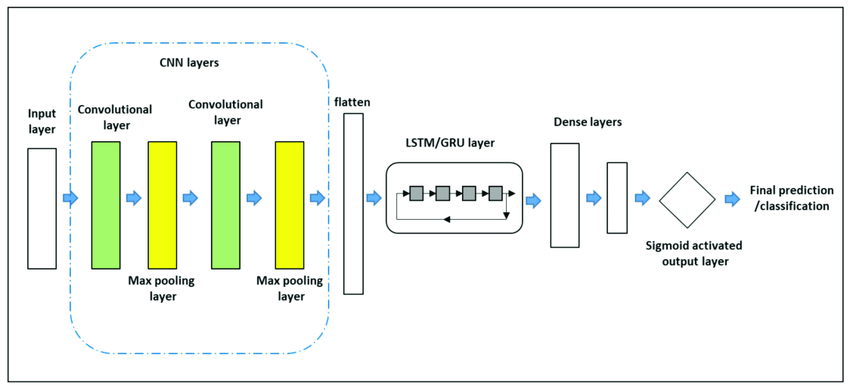

In [29]:
model = Sequential()
model.add(InputLayer(input_shape=(max_length,)))
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(512, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)))
model.add(Bidirectional(LSTM(128, activation='tanh', recurrent_activation='sigmoid')))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

metrics = [
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 942, 128)          3781888   
                                                                 
 conv1d_1 (Conv1D)           (None, 942, 64)           24640     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 471, 64)           0         
 g1D)                                                            
                                                                 
 bidirectional_2 (Bidirecti  (None, 471, 1024)         2363392   
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 256)               1180672   
 onal)                                                           
                                                      

##**Model training**

In [32]:
model.fit(X_Train, y_Train,
          validation_data=(X_validation, y_validation),
          epochs=5,
          batch_size=64,
          callbacks=[
              tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001),
              tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
          ])

model.evaluate(X_test_, y_test)

Epoch 1/5
65/65 [==============================] - 22s 344ms/step - loss: 0.2814 - precision: 0.9240 - recall: 0.8636 - val_loss: 0.4761 - val_precision: 0.8580 - val_recall: 0.7824 - lr: 5.0000e-04
Epoch 2/5
65/65 [==============================] - 24s 371ms/step - loss: 0.1230 - precision: 0.9674 - recall: 0.9554 - val_loss: 0.7310 - val_precision: 0.8173 - val_recall: 0.7644 - lr: 5.0000e-04
Epoch 3/5
65/65 [==============================] - 24s 372ms/step - loss: 0.0473 - precision: 0.9881 - recall: 0.9868 - val_loss: 0.8158 - val_precision: 0.7956 - val_recall: 0.7842 - lr: 5.0000e-04
Epoch 4/5
65/65 [==============================] - 22s 345ms/step - loss: 0.0164 - precision: 0.9951 - recall: 0.9951 - val_loss: 1.3715 - val_precision: 0.8350 - val_recall: 0.7554 - lr: 5.0000e-04
Epoch 5/5
41/41 [==============================] - 3s 74ms/step - loss: 0.8826 - precision: 0.8606 - recall: 0.7629


[0.8826351165771484, 0.8606159090995789, 0.7629310488700867]

##**Model Performance**

In [33]:
y_pred = model.predict(X_test_)
y_pred= np.where(y_pred > 0.5, 1, 0).flatten()

print(classification_report(y_test, y_pred))
print(y_pred)

41/41 [==============================] - 4s 86ms/step
              precision    recall  f1-score   support

           0       0.76      0.86      0.80       604
           1       0.86      0.76      0.81       696

    accuracy                           0.81      1300
   macro avg       0.81      0.81      0.81      1300
weighted avg       0.81      0.81      0.81      1300

[0 0 1 ... 1 1 1]


In [ ]:
#model.save('/content/drive/MyDrive/Colab Notebooks/LSTM_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
